In [33]:
import os

#os.chdir("/drive/MyDrive/data")

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import random
import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [34]:
diego = np.load("diego.npy",allow_pickle=True)

In [35]:
diego[0,0].shape

(128, 513)

In [36]:
from torch.utils.data import Dataset, DataLoader

#Class for the creation of torch manageble datasets, with Format one can select the desired input column 
class DataDiego(Dataset):

    def __init__(self, data, transform=None):
        self.x = data[:,0]
        self.y = data[:,1]
        self.transform = transform

    def __len__(self):
       
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
            #x = x.unsqueeze(0)
            
        return x, y

In [37]:
transforms = Compose([
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
])

In [38]:
test_dataset = DataDiego(data=diego,transform=transforms)
#Creation of dataloader classes
batch_size = 64
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

In [39]:
class NNET2(nn.Module):
        
    def __init__(self):
        super(NNET2, self).__init__()
        
        
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256,kernel_size=(4,513)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 1),padding=(2,0)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 1),padding=(1,0)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256, 300),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 8),
            nn.Softmax(dim=1)
        )

    def forward(self,x):
        
        c1 = self.c1(x)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        x = c1 + c3
        max_pool = F.max_pool2d(x, kernel_size=(125,1))
        avg_pool = F.avg_pool2d(x, kernel_size=(125,1))
        x = max_pool + avg_pool
        x = self.fc(x.view(-1, 256))
        return x 




In [41]:
from torch.optim import SGD, Adam, Adadelta
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
# Create model
model = NNET2()
opt = Adadelta(model.parameters())

loss_fn = CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf
train_loss = np.array([])
validation_loss = np.array([])
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(test_dataloader)

    loss_batch = np.array([])
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)
        

        loss = loss_fn(y_pred, batch_y)

        loss_batch = np.append(loss_batch,loss.detach().numpy())

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    avg_loss_epoch = np.mean(loss_batch)
    train_loss = np.append(train_loss, avg_loss_epoch)


    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        validation_loss = np.append(validation_loss,1 - val_acc)
        print(f"loss: {val_loss}, accuracy: {val_acc}")
    
    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


loss: 1.5644688606262207, accuracy: 0.16776315867900848
Saved Model
Epoch: 2


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


loss: 1.5147600173950195, accuracy: 0.15328946709632874
Saved Model
Epoch: 3


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


loss: 1.490737795829773, accuracy: 0.125
Saved Model
Epoch: 4


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


loss: 1.5620465278625488, accuracy: 0.5763157606124878
Epoch: 5


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


loss: 1.4735634326934814, accuracy: 0.23289473354816437
Saved Model
Epoch: 6


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


loss: 1.4750375747680664, accuracy: 0.6453947424888611
Epoch: 7


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


loss: 1.4637298583984375, accuracy: 0.5657894611358643
Saved Model
Epoch: 8


100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


loss: 1.4624605178833008, accuracy: 0.47894737124443054
Saved Model
Epoch: 9


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


loss: 1.3582643270492554, accuracy: 0.32697367668151855
Saved Model
Epoch: 10


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


loss: 1.3383480310440063, accuracy: 0.2789473831653595
Saved Model


Text(0.5, 1.0, 'swag berlusconi')

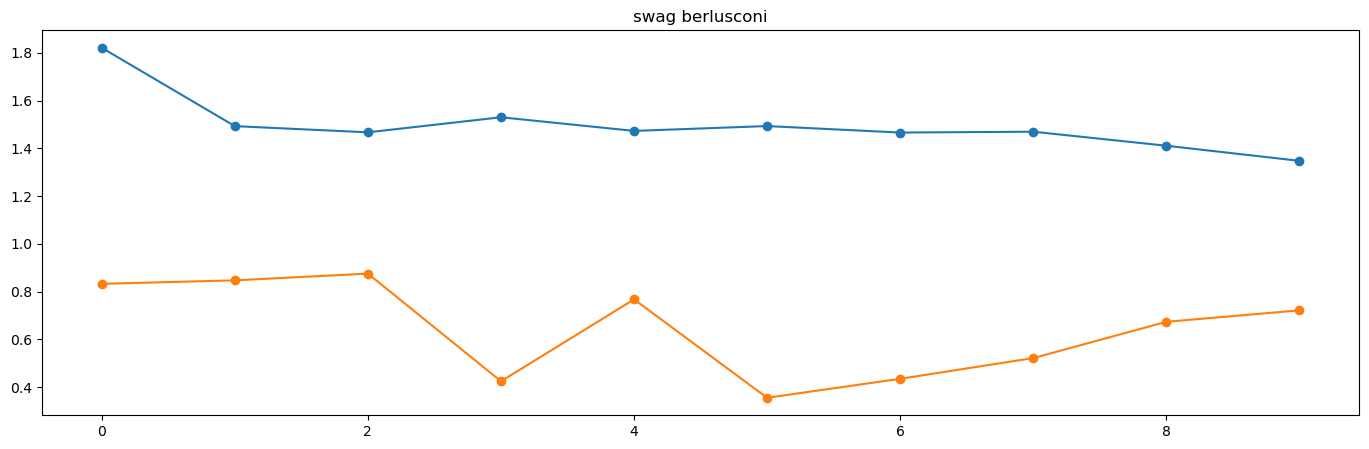

In [46]:
plt.plot(train_loss,'o-')
plt.plot(validation_loss,'o-')
plt.title("swag berlusconi")